In [82]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
dados_train = pd.read_csv('dados/aug_train.csv')
dados_test = pd.read_csv('dados/aug_test.csv')

In [4]:
len(dados_train)

19158

In [5]:
len(dados_test)

2129

## Tratamento dos dados de Treinamento e Teste

In [6]:
dados_test['target'] = -1.0
dataset = pd.concat([dados_train,dados_test])
len(dataset)

21287

In [7]:
dataset.shape

(21287, 14)

In [8]:
dataset.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [9]:
#analisar percentual de valores faltantes no dataset
for value in dataset.columns:
    print(value," ",(dataset[value].isna().sum()/len(dataset))*100)

enrollee_id   0.0
city   0.0
city_development_index   0.0
gender   23.563677361770093
relevent_experience   0.0
enrolled_university   1.9589420773241883
education_level   2.405223845539531
major_discipline   14.680321322873116
experience   0.3288391976323578
company_size   30.816930520975244
company_type   31.822238925165593
last_new_job   2.1750364071968806
training_hours   0.0
target   0.0


In [10]:
#remoção da coluna id, pois como ids são identificadores, não serão utilizados na análise
dataset.drop(['enrollee_id'],axis = 1,inplace= True)

In [11]:
# Analisar os valores de algumas das variáveis já observadas no momento da plotagem do head
for value in ['experience','last_new_job','company_size','company_type']:
    print(value," ",dataset[value].value_counts().index.tolist())

experience   ['>20', '5', '4', '3', '6', '2', '7', '9', '10', '8', '11', '15', '14', '1', '<1', '16', '12', '13', '17', '19', '18', '20']
last_new_job   ['1', '>4', '2', 'never', '3', '4']
company_size   ['50-99', '100-500', '10000+', '10/49', '<10', '1000-4999', '500-999', '5000-9999']
company_type   ['Pvt Ltd', 'Funded Startup', 'Public Sector', 'Early Stage Startup', 'NGO', 'Other']


In [12]:
'''Identificamos que em algumas variáveis, alguns atributos que estão fora do padrão ou que possuem 
informação a mais, tendo isso será feito um replace dessas informações'''

dataset['city'] = dataset['city'].replace('city_',"", regex=True)
dataset['experience'] = dataset['experience'].replace(['>20','<1'],[21,0], regex=True)
dataset['last_new_job'] = dataset['last_new_job'].replace(['>4','never'],[5,0],regex=True)

print(dataset['city'].value_counts(),
      dataset['experience'].value_counts(),
      dataset['last_new_job'].value_counts())

103    4828
21     3020
16     1701
114    1491
160     958
       ... 
8         4
111       3
129       3
171       2
140       1
Name: city, Length: 123, dtype: int64 21    3669
5     1593
4     1548
3     1508
6     1346
2     1255
7     1144
9     1093
10    1081
8      884
11     750
15     745
14     641
1      605
0      596
16     576
12     546
13     453
17     378
19     333
18     306
20     167
Name: experience, dtype: int64 1    8924
5    3643
2    3242
0    2710
3    1157
4    1148
Name: last_new_job, dtype: int64


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    21287 non-null  object 
 1   city_development_index  21287 non-null  float64
 2   gender                  16271 non-null  object 
 3   relevent_experience     21287 non-null  object 
 4   enrolled_university     20870 non-null  object 
 5   education_level         20775 non-null  object 
 6   major_discipline        18162 non-null  object 
 7   experience              21217 non-null  object 
 8   company_size            14727 non-null  object 
 9   company_type            14513 non-null  object 
 10  last_new_job            20824 non-null  object 
 11  training_hours          21287 non-null  int64  
 12  target                  21287 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.3+ MB


In [14]:
# Analise IV e woe para as variáveis categóricas em relação a variável target, essa análise será feita
# apenas para os dados de treino essa análise e o resultado da análise será aplicado no dataset
# principal
for i in dados_train.drop(columns = ['target',
                            'city',
                            'city_development_index',
                            'training_hours',
                            'experience',
                            'last_new_job',
                            'company_size']).columns:
  
    df_woe_iv = (pd.crosstab(dados_train[i], dados_train['target'], normalize = 'columns')
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['woe'] * (dfx[1]-dfx[0]))))
    
    print(df_woe_iv,'\n------------------------------------------------------------')

target           0.0       1.0  woe   iv
enrollee_id                             
1            0.00007  0.000000 -inf  inf
2            0.00000  0.000209  inf  inf
4            0.00007  0.000000 -inf  inf
5            0.00007  0.000000 -inf  inf
7            0.00007  0.000000 -inf  inf
...              ...       ...  ...  ...
33375        0.00007  0.000000 -inf  inf
33376        0.00007  0.000000 -inf  inf
33377        0.00007  0.000000 -inf  inf
33379        0.00007  0.000000 -inf  inf
33380        0.00007  0.000000 -inf  inf

[19158 rows x 4 columns] 
------------------------------------------------------------
target      0.0       1.0       woe        iv
gender                                       
Female  0.08098  0.096222  0.172452  0.003337
Male    0.90650  0.889020 -0.019471  0.003337
Other   0.01252  0.014758  0.164458  0.003337 
------------------------------------------------------------
target                        0.0       1.0       woe        iv
relevent_experience    

C:\Users\Anaconda\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
'''Analisando o IV sobre os dados de treino iremos excluir as variáveis 'major_discipline' e 'gender'
pois possuem uma relação muito fraca com a variável target, sendo esse procedimento feito no
dataset principal'''

dataset.drop(['major_discipline','gender'],axis = 1,inplace=True)
dataset.head()

,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,company_type,last_new_job,training_hours,target
0,103,0.920,Has relevent experience,no_enrollment,Graduate,21,NaN,NaN,1,36,1.0
1,40,0.776,No relevent experience,no_enrollment,Graduate,15,50-99,Pvt Ltd,5,47,0.0
2,21,0.624,No relevent experience,Full time course,Graduate,5,NaN,NaN,0,83,0.0
3,115,0.789,No relevent experience,NaN,Graduate,0,NaN,Pvt Ltd,0,52,1.0
4,162,0.767,Has relevent experience,no_enrollment,Masters,21,50-99,Funded Startup,4,8,0.0


<AxesSubplot:>

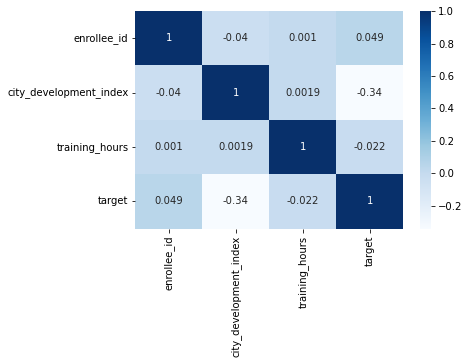

In [16]:
# Analise de correlação das variáveis numéricas em relação a variável target
# Apenas para os dados de treino essa análise e o resultado será aplicado no dataset principal
corr = dados_train.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [17]:
''' Devido a uma baixa relação com a variável target a variável no dataset de treino 
'city_development_index' será removida do nosso dataset principal'''

dataset.drop(['city_development_index'],axis=1,inplace=True)
dataset.head()

,city,relevent_experience,enrolled_university,education_level,experience,company_size,company_type,last_new_job,training_hours,target
0,103,Has relevent experience,no_enrollment,Graduate,21,NaN,NaN,1,36,1.0
1,40,No relevent experience,no_enrollment,Graduate,15,50-99,Pvt Ltd,5,47,0.0
2,21,No relevent experience,Full time course,Graduate,5,NaN,NaN,0,83,0.0
3,115,No relevent experience,NaN,Graduate,0,NaN,Pvt Ltd,0,52,1.0
4,162,Has relevent experience,no_enrollment,Masters,21,50-99,Funded Startup,4,8,0.0


In [18]:
# imputação de valores nas variáveis 'education_level', 'enrolled_university' e 'company_type'
dataset['company_type'].replace(np.nan,'Other',regex=True,inplace=True)

dataset['education_level'] = np.where(((dataset['enrolled_university'] == 'Full time course')
                                          | (dataset['enrolled_university'] == 'Part time course')
                                          & (dataset['education_level'] == np.nan)),
                                         'High School',dataset['education_level'])

dataset['enrolled_university'] = np.where(((dataset['education_level'] == 'Primary School') &
                                               (dataset['enrolled_university'] == np.nan)),
                                               'no_enrollment',dataset['education_level'])

#Imputação do valor 'Other' no lugar de NaN no atributo company_size
dataset['company_size'] = dataset['company_size'].fillna('Other')

# Padronização dos dados da variável 'company_size'
dataset['company_size'] = dataset['company_size'].replace(['10/49','<10'],
                                                                  ['10-49','1-10'],regex=True)

In [19]:
#analisar percentual de valores faltantes no dataset
for value in dataset.columns:
    print(value," ",(dataset[value].isna().sum()/len(dataset))*100)

city   0.0
relevent_experience   0.0
enrolled_university   2.02470991685066
education_level   2.02470991685066
experience   0.3288391976323578
company_size   0.0
company_type   0.0
last_new_job   2.1750364071968806
training_hours   0.0
target   0.0


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 21287 non-null  object 
 1   relevent_experience  21287 non-null  object 
 2   enrolled_university  20856 non-null  object 
 3   education_level      20856 non-null  object 
 4   experience           21217 non-null  object 
 5   company_size         21287 non-null  object 
 6   company_type         21287 non-null  object 
 7   last_new_job         20824 non-null  object 
 8   training_hours       21287 non-null  int64  
 9   target               21287 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 1.8+ MB


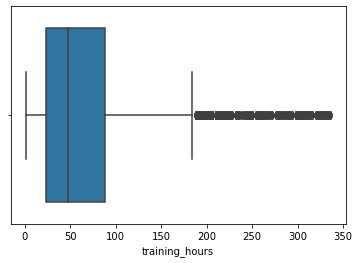

In [21]:
# Identificação de outliers na variável 'training_hours'
ax = sb.boxplot(x=dataset["training_hours"])

In [22]:
# Tratamento dos outliers, tranformando os mesmos nos maiores e menores valores do range boxplot
Q1, Q3 = dataset["training_hours"].quantile(0.25), dataset["training_hours"].quantile(0.75)
IQR = Q3 - Q1
cut_off = IQR * 1.5
lower, upper = Q1 - cut_off, Q3 + cut_off

dataset["training_hours"] = np.where(dataset["training_hours"] > upper, upper, dataset["training_hours"])
dataset["training_hours"] = np.where(dataset["training_hours"] < lower, lower, dataset["training_hours"])

In [23]:
# Conversão de series numéricas em string para formato mais adequado

dataset["experience"] = pd.to_numeric(dataset["experience"])
dataset["city"] = pd.to_numeric(dataset["city"])
dataset["last_new_job"] = pd.to_numeric(dataset["last_new_job"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 21287 non-null  int64  
 1   relevent_experience  21287 non-null  object 
 2   enrolled_university  20856 non-null  object 
 3   education_level      20856 non-null  object 
 4   experience           21217 non-null  float64
 5   company_size         21287 non-null  object 
 6   company_type         21287 non-null  object 
 7   last_new_job         20824 non-null  float64
 8   training_hours       21287 non-null  float64
 9   target               21287 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.8+ MB


In [24]:
dataset.dropna(inplace=True)

In [25]:
# Encoding das variáveis categoricas para uso no processo de predição
label = preprocessing.LabelEncoder()

label.fit(dataset["relevent_experience"])
dataset["relevent_experience"] = label.transform(dataset["relevent_experience"])

label.fit(dataset["enrolled_university"])
dataset["enrolled_university"] = label.transform(dataset["enrolled_university"])

label.fit(dataset["education_level"])
dataset["education_level"] = label.transform(dataset["education_level"])

label.fit(dataset["company_size"])
dataset["company_size"] = label.transform(dataset["company_size"])

label.fit(dataset["company_type"])
dataset["company_type"] = label.transform(dataset["company_type"])
dataset.head()

,city,relevent_experience,enrolled_university,education_level,experience,company_size,company_type,last_new_job,training_hours,target
0,103,0,0,0,21.0,8,3,1.0,36.0,1.0
1,40,1,0,0,15.0,5,5,5.0,47.0,0.0
2,21,1,1,1,5.0,8,3,0.0,83.0,0.0
3,115,1,0,0,0.0,8,5,0.0,52.0,1.0
4,162,0,2,2,21.0,5,1,4.0,8.0,0.0


### Treino e Teste de Modelo de Machine Learning (Preditor Gaussiano)

In [50]:
# separação dos dados de treino e teste
x_data = dataset.drop(['target'],axis=1)
y_data = dataset['target']

In [78]:
# Realização do Treino e do teste utilizando modelos Gaussiano
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.4)
gnb = GaussianNB()

gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

In [79]:
# Acurácia Comparativa entre o que foi previsto e os dados reais
metrics.accuracy_score(y_test, y_pred)

0.6622946800686442

### Treino e Teste de Modelo de Machine Learning (Preditor KNN)

In [87]:
# Realização do Treino e do teste utilizando modelo KNeighbors
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.4)
knc = KNeighborsClassifier()

knc.fit(x_train, y_train)
y_pred = knc.predict(x_test)

In [88]:
# Acurácia Comparativa entre o que foi previsto e os dados reais
metrics.accuracy_score(y_test, y_pred)

0.6528560921794557

### Treino e Teste de Modelo de Machine Learning (Árvore de Decisão)

In [89]:
# Realização do Treino e do teste utilizando modelo KNeighbors
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.4)
dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)

In [90]:
# Acurácia Comparativa entre o que foi previsto e os dados reais
metrics.accuracy_score(y_test, y_pred)

0.5720764893356215

**Entre os 3 preditores o que teve melhor performance para o cenário abordado foi o modelo Gaussiano, obtendo uma acurácia superior a 66% no processo de predição**